# **Ekstraksi Fitur Audio dengan 3 Domain**
Dataset menggunakan data voice 150 buka dan 150 tutup dengan format .wav yang di rekam oleh 2 orang

In [1]:
pip install tsfel librosa pandas scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 37.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [tsfel]m12/13 [tsfel]a]els]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tsfel
import librosa
import numpy as np
import pandas as pd
import os


In [ ]:
import os

# Langsung akses folder di dalam direktori saat ini
path_buka = 'buka_wav'
path_tutup = 'tutup_wav'

# Cek apakah folder terbaca
print("Isi folder buka_wav:", os.listdir(path_buka)[:5])
print("Isi folder tutup_wav:", os.listdir(path_tutup)[:5])


Isi folder buka_wav: ['20251108_134440.wav', '20251109_175536.wav', 'buka (32).wav', '20251108_134636.wav', 'buka (14).wav']
Isi folder tutup_wav: ['20251108_133928.wav', '20251109_180213.wav', 'tutup (67).wav', 'tutup (62).wav', 'tutup (92).wav']


## **Preprocessing Data**

### **Ekstraksi fitur domain statistical, temporal, dan spectral**

In [4]:
# === Ambil konfigurasi fitur dari 3 domain ===
cfg_stat = tsfel.get_features_by_domain('statistical')
cfg_temp = tsfel.get_features_by_domain('temporal')
cfg_spec = tsfel.get_features_by_domain('spectral')

def extract_tsfel_features():
    features = []
    labels = []

    for label in ['buka_wav', 'tutup_wav']:
        folder_path = label  # langsung pakai nama folder
        print(f"🔍 Memproses folder: {label} ...")

        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)

                try:
                    # Load file audio
                    y, sr = librosa.load(file_path, sr=None)

                    # === Ekstraksi 3 domain fitur TSFEL ===
                    df_stat = tsfel.time_series_features_extractor(cfg_stat, y, fs=sr, verbose=0)
                    df_temp = tsfel.time_series_features_extractor(cfg_temp, y, fs=sr, verbose=0)
                    df_spec = tsfel.time_series_features_extractor(cfg_spec, y, fs=sr, verbose=0)

                    # === Gabungkan ketiganya jadi satu DataFrame ===
                    df_all = pd.concat([df_stat, df_temp, df_spec], axis=1)

                    # Ambil rata-rata tiap kolom (supaya 1 baris per file)
                    feat_mean = df_all.mean().values
                    features.append(feat_mean)
                    labels.append(label.replace('_wav', ''))

                except Exception as e:
                    print(f"⚠️ Gagal memproses {file_path}: {e}")

    # === Gabungkan hasil ke DataFrame ===
    X = pd.DataFrame(features, columns=df_all.columns)
    y = pd.Series(labels, name='label')
    return X, y


# === Jalankan ekstraksi ===
X, y = extract_tsfel_features()

print("Jumlah data:", len(X))
print("Jumlah fitur:", X.shape[1])
print("Label unik:", y.unique())


🔍 Memproses folder: buka_wav ...
🔍 Memproses folder: tutup_wav ...
Jumlah data: 400
Jumlah fitur: 156
Label unik: ['buka' 'tutup']


### **Seleksi Fitur menggunakan Information Gain**
seleksi fitur untuk mencari kolom dengan nilai gain tertinggi hingga terendah

In [7]:
# Information Gain
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt

# Misal X = fitur hasil ekstraksi, y = label
# Pastikan y sudah berbentuk numerik (0/1)
y_encoded = y.replace({'buka': 0, 'tutup': 1})

# === Hitung Information Gain ===
info_gain = mutual_info_classif(X, y_encoded, random_state=42)

# === Buat DataFrame ranking ===
ig_df = pd.DataFrame({
    'kolom': X.columns,
    'Information_Gain': info_gain
}).sort_values(by='Information_Gain', ascending=False)

# === Tampilkan hasil ===
print("🔍 Ranking Fitur berdasarkan Information Gain:")
display(ig_df.head(156))


/tmp/ipykernel_8299/738628617.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_encoded = y.replace({'buka': 0, 'tutup': 1})


🔍 Ranking Fitur berdasarkan Information Gain:


,kolom,Information_Gain
73,0_Median frequency,0.389440
45,0_Fundamental frequency,0.338354
32,0_Autocorrelation,0.288566
74,0_Power bandwidth,0.281344
82,0_Spectral roll-on,0.257268
...,...,...
63,0_MFCC_2,0.000000
62,0_MFCC_11,0.000000
70,0_MFCC_9,0.000000
68,0_MFCC_7,0.000000


📊 Statistik Information Gain:
🔹 Total fitur          : 156
🔹 Fitur dengan IG > 0  : 145
🔹 Fitur dengan IG = 0  : 11
🔹 Persentase relevan   : 92.95%


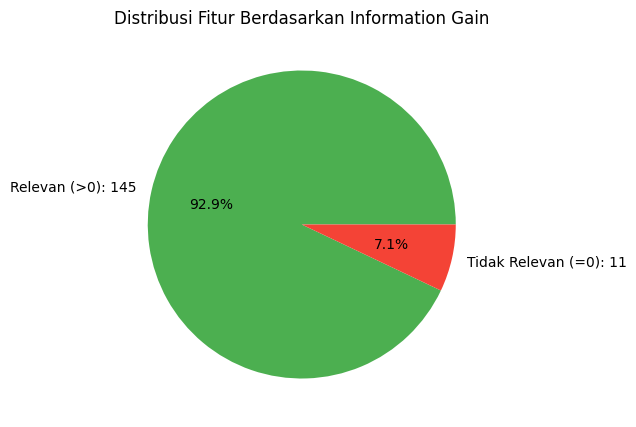

In [8]:
# Hitung jumlah fitur yang memiliki nilai IG > 0 dan = 0
n_nonzero = (ig_df['Information_Gain'] > 0).sum()
n_zero = (ig_df['Information_Gain'] == 0).sum()
total = len(ig_df)

print("📊 Statistik Information Gain:")
print(f"🔹 Total fitur          : {total}")
print(f"🔹 Fitur dengan IG > 0  : {n_nonzero}")
print(f"🔹 Fitur dengan IG = 0  : {n_zero}")
print(f"🔹 Persentase relevan   : {(n_nonzero/total)*100:.2f}%")

# (Opsional) visualisasi pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    [n_nonzero, n_zero],
    labels=[f'Relevan (>0): {n_nonzero}', f'Tidak Relevan (=0): {n_zero}'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#F44336']
)
plt.title('Distribusi Fitur Berdasarkan Information Gain')
plt.show()


### **Hitung Akurasi Sementara**
Menghitung akurasi dengan menggunakan jumlah fitur yang berbeda-beda dengan model random forest untuk mencari jumlah fitur terbaik untuk klasifikasi

   Top_N_Fitur  Akurasi
0           15   0.9500
1           20   0.9750
2          100   0.9750
3          144   0.9875
4          145   0.9875
5          156   0.9750


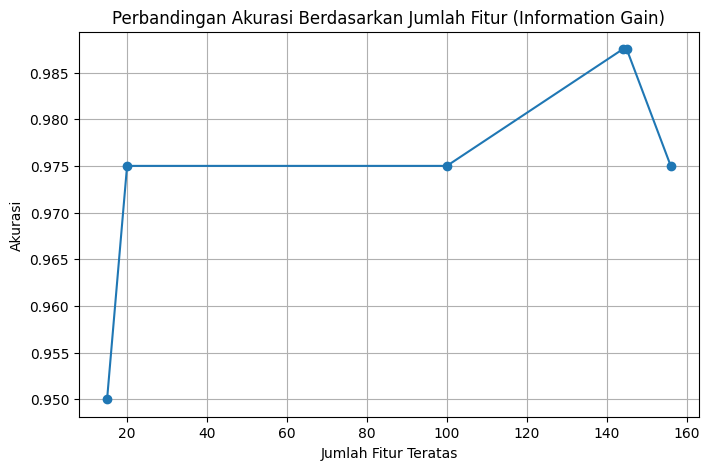

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Ambil ranking fitur berdasarkan Information Gain (dari ig_df sebelumnya)
ig_sorted = ig_df.sort_values(by="Information_Gain", ascending=False)
fitur_ranking = ig_sorted['kolom'].values

# Siapkan list untuk menyimpan hasil
hasil_akurasi = []

# Definisikan beberapa jumlah fitur yang akan diuji
n_features_list = [15,20,100,144,145, len(fitur_ranking)]

# Loop untuk setiap jumlah fitur
for n in n_features_list:
    fitur_terpilih = fitur_ranking[:n]
    X_subset = X[fitur_terpilih]

    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)

    # Latih model Random Forest
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    # Prediksi dan hitung akurasi
    y_pred = model.predict(X_test)
    akurasi = accuracy_score(y_test, y_pred)

    hasil_akurasi.append({'Top_N_Fitur': n, 'Akurasi': akurasi})

# Ubah ke DataFrame untuk tampilan
df_hasil = pd.DataFrame(hasil_akurasi)
print(df_hasil)

# Visualisasi hasil akurasi
plt.figure(figsize=(8,5))
plt.plot(df_hasil['Top_N_Fitur'], df_hasil['Akurasi'], marker='o')
plt.title('Perbandingan Akurasi Berdasarkan Jumlah Fitur (Information Gain)')
plt.xlabel('Jumlah Fitur Teratas')
plt.ylabel('Akurasi')
plt.grid(True)
plt.show()



In [8]:
# === fitur teratas ===
top_n = 144
top_df = ig_df.head(top_n)

# Tampilkan fitur teratas
print(f"📊 Fitur Teratas berdasarkan Information Gain:")
display(top_df)

📊 Fitur Teratas berdasarkan Information Gain:


,kolom,Information_Gain
73,0_Median frequency,0.389440
45,0_Fundamental frequency,0.338354
32,0_Autocorrelation,0.288566
74,0_Power bandwidth,0.281344
82,0_Spectral roll-on,0.257268
...,...,...
53,0_LPCC_4,0.017761
59,0_MFCC_0,0.017046
126,0_Wavelet absolute mean_4000.0Hz,0.013177
37,0_Median diff,0.012636


In [9]:
# === Ambil fitur teratas berdasarkan Information Gain ===
top_n = 144
top_features = ig_df['kolom'].head(top_n).values

# === Ambil nilai fitur dari X sesuai fitur teratas ===
X_top = X[top_features]

# === Gabungkan label (opsional, biar tahu mana buka/tutup) ===
X_top_label = pd.concat([X_top, y.reset_index(drop=True)], axis=1)

# === Tampilkan hasil ===
print(f"📊 Data fitur teratas dengan nilainya (total {X_top.shape[0]} baris):")
display(X_top_label.head())

📊 Data fitur teratas dengan nilainya (total 400 baris):


,0_Median frequency,0_Fundamental frequency,0_Autocorrelation,0_Power bandwidth,0_Spectral roll-on,0_Spectral entropy,0_Spectrogram mean coefficient_24000.0Hz,0_Spectrogram mean coefficient_5419.35Hz,0_Spectrogram mean coefficient_3096.77Hz,0_Spectral variation,...,0_MFCC_10,0_Wavelet variance_6000.0Hz,0_Wavelet absolute mean_1333.33Hz,0_LPCC_8,0_LPCC_4,0_MFCC_0,0_Wavelet absolute mean_4000.0Hz,0_Median diff,0_Spectral positive turning points,label
0,604.083252,149.194336,20.0,736.358643,155.731201,0.581808,1.574587e-08,7.793430e-10,9.998587e-09,0.012325,...,-1.188804e-07,0.000071,4.446153e-07,1.638527,1.638527,-1.000000e-08,2.129262e-07,0.0,16431.0,buka
1,614.493815,148.339844,19.0,1220.214844,153.922526,0.550570,2.295810e-08,1.189163e-09,1.478289e-08,0.032199,...,-1.188804e-07,0.000142,6.265394e-07,0.848323,0.848323,-1.000000e-08,1.232459e-07,0.0,13786.0,buka
2,801.155116,127.062706,15.0,634.488449,186.056106,0.623160,2.379245e-14,5.120234e-09,6.779366e-08,0.010713,...,-1.188804e-07,0.000202,1.337835e-07,0.215414,0.215414,-1.000000e-08,1.774681e-08,0.0,15562.0,buka
3,614.782827,154.881021,19.0,770.058952,157.251649,0.535200,2.404672e-08,7.915491e-10,1.433025e-08,0.020393,...,-1.188804e-07,0.000108,3.579363e-07,1.449418,1.449418,-1.000000e-08,6.413027e-08,0.0,15068.0,buka
4,835.648148,128.472222,13.0,1145.833333,175.925926,0.630435,4.838172e-14,7.161570e-09,7.912270e-08,0.023979,...,-1.188804e-07,0.000348,1.465636e-07,0.032892,0.032892,-1.000000e-08,5.989375e-08,0.0,11829.0,buka


In [10]:
# === Simpan ke file CSV ===
X_top_label.to_csv("top_fitur_dengan_label.csv", index=False)
print("✅ File 'top_fitur_dengan_label.csv' berhasil disimpan di folder kerja saat ini!")

✅ File 'top_fitur_dengan_label.csv' berhasil disimpan di folder kerja saat ini!


### **Load Dataframe baru**

In [11]:
# Path ke file fitur hasil ekstraksi
csv_path = "top_fitur_dengan_label.csv"

# Load dataset
df = pd.read_csv(csv_path)
print("✅ Data berhasil dimuat!")
print("Ukuran data:", df.shape)
df.head()


✅ Data berhasil dimuat!
Ukuran data: (400, 145)


,0_Median frequency,0_Fundamental frequency,0_Autocorrelation,0_Power bandwidth,0_Spectral roll-on,0_Spectral entropy,0_Spectrogram mean coefficient_24000.0Hz,0_Spectrogram mean coefficient_5419.35Hz,0_Spectrogram mean coefficient_3096.77Hz,0_Spectral variation,...,0_MFCC_10,0_Wavelet variance_6000.0Hz,0_Wavelet absolute mean_1333.33Hz,0_LPCC_8,0_LPCC_4,0_MFCC_0,0_Wavelet absolute mean_4000.0Hz,0_Median diff,0_Spectral positive turning points,label
0,604.083252,149.194336,20.0,736.358643,155.731201,0.581808,1.574587e-08,7.793430e-10,9.998587e-09,0.012325,...,-1.188804e-07,0.000071,4.446153e-07,1.638527,1.638527,-1.000000e-08,2.129262e-07,0.0,16431.0,buka
1,614.493815,148.339844,19.0,1220.214844,153.922526,0.550570,2.295810e-08,1.189163e-09,1.478289e-08,0.032199,...,-1.188804e-07,0.000142,6.265394e-07,0.848323,0.848323,-1.000000e-08,1.232459e-07,0.0,13786.0,buka
2,801.155116,127.062706,15.0,634.488449,186.056106,0.623160,2.379245e-14,5.120234e-09,6.779366e-08,0.010713,...,-1.188804e-07,0.000202,1.337835e-07,0.215414,0.215414,-1.000000e-08,1.774681e-08,0.0,15562.0,buka
3,614.782827,154.881021,19.0,770.058952,157.251649,0.535200,2.404672e-08,7.915491e-10,1.433025e-08,0.020393,...,-1.188804e-07,0.000108,3.579363e-07,1.449418,1.449418,-1.000000e-08,6.413027e-08,0.0,15068.0,buka
4,835.648148,128.472222,13.0,1145.833333,175.925926,0.630435,4.838172e-14,7.161570e-09,7.912270e-08,0.023979,...,-1.188804e-07,0.000348,1.465636e-07,0.032892,0.032892,-1.000000e-08,5.989375e-08,0.0,11829.0,buka


In [12]:
# Pisahkan fitur dan label
X = df.drop('label', axis=1)
y = df['label']

print("Jumlah data:", len(X))
print("Jumlah fitur:", X.shape[1])
print("Label unik:", y.unique())
print(y.value_counts())

Jumlah data: 400
Jumlah fitur: 144
Label unik: ['buka' 'tutup']
label
buka     200
tutup    200
Name: count, dtype: int64


### **Cek Missing Value**

In [13]:
# cek missing value
print("Jumlah missing value:", X.isna().sum().sum())

# Jika ada NaN atau inf, ganti dengan 0
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)


Jumlah missing value: 0


### **Deteksi Outlier dengan LoF**

In [14]:
from sklearn.neighbors import LocalOutlierFactor

# Inisialisasi LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Fit dan prediksi (-1 = outlier, 1 = normal)
y_pred_outlier = lof.fit_predict(X)

# Ambil data yang normal saja
mask_normal = y_pred_outlier == 1
X_lof = X[mask_normal]
y_lof = y[mask_normal]

print(f"Jumlah data awal: {len(X)}")
print(f"Jumlah data setelah buang outlier (LOF): {len(X_lof)}")
print(f"Outlier terdeteksi: {np.sum(y_pred_outlier == -1)} baris")


Jumlah data awal: 400
Jumlah data setelah buang outlier (LOF): 380
Outlier terdeteksi: 20 baris


### **Normalisasi**

In [15]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lof)

# Simpan scaler(supaya nanti bisa dipakai di Streamlit)
joblib.dump(scaler, 'scaler_tsfel.pkl')
print("✅ Scaler tersimpan!")


✅ Scaler tersimpan!


In [16]:
# Gabungkan kembali jadi DataFrame agar mudah dipakai nanti
X_clean = pd.DataFrame(X_scaled, columns=X_lof.columns)
X_clean['label'] = y_lof.values

# Simpan 
X_clean.to_csv('fitur_tsfel_clean.csv', index=False)
print("✅ Dataset bersih (LOF + Normalisasi) disimpan!")


✅ Dataset bersih (LOF + Normalisasi) disimpan!


### **Visualisasi Data**

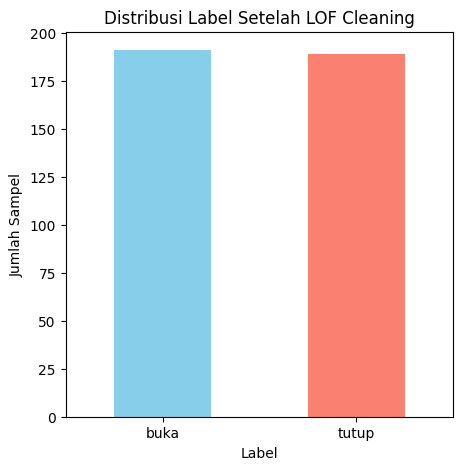

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
y_lof.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Label Setelah LOF Cleaning')
plt.xlabel('Label')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=0)
plt.show()


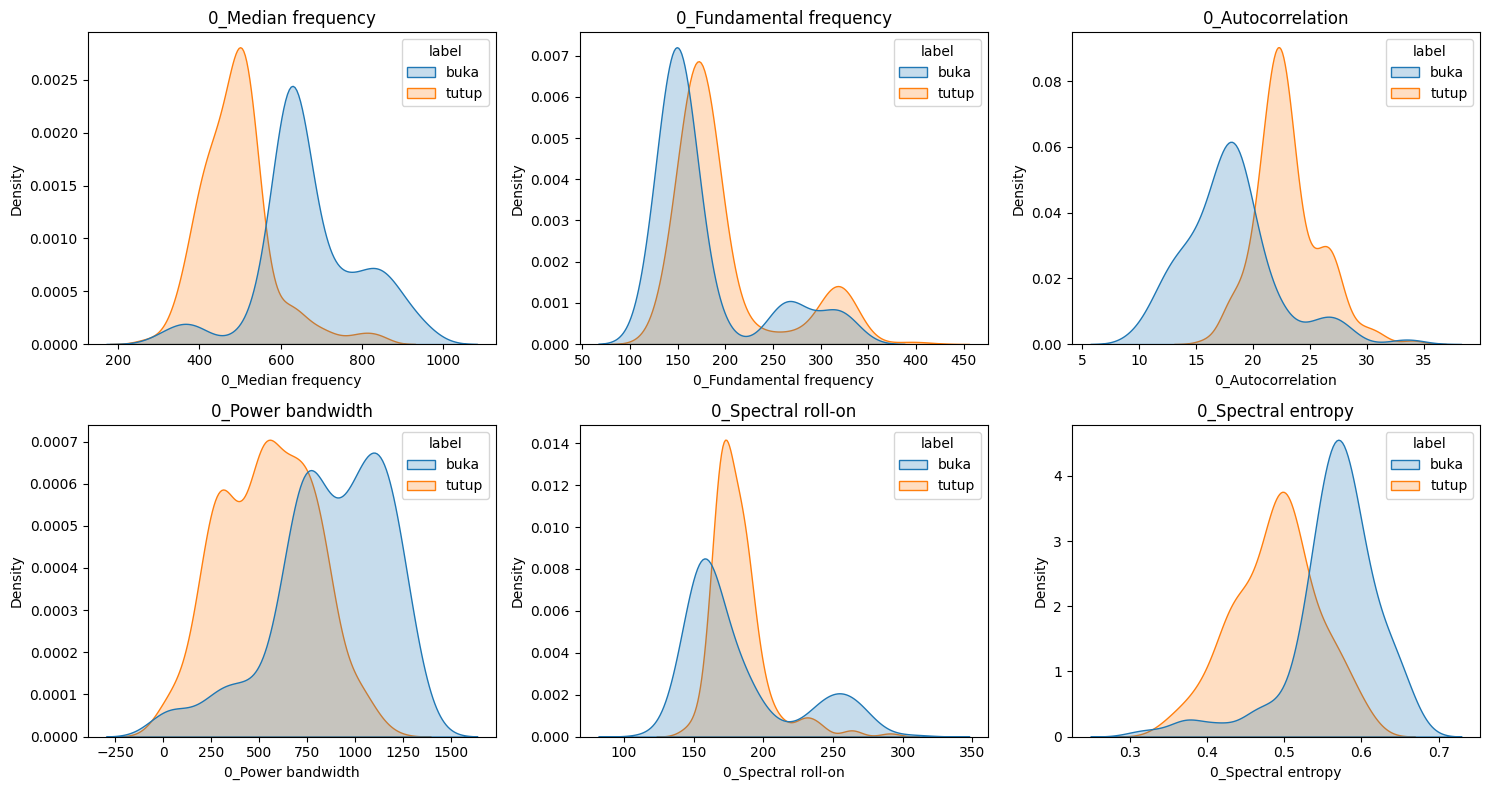

In [18]:
import seaborn as sns
import pandas as pd

# Buat dataframe gabungan
df_clean = X_lof.copy()
df_clean['label'] = y_lof.values

# Pilih 5 fitur acak untuk ditampilkan
sample_features = df_clean.columns[:6]

plt.figure(figsize=(15,8))
for i, col in enumerate(sample_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df_clean, x=col, hue='label', fill=True)
    plt.title(col)
plt.tight_layout()
plt.show()


/tmp/ipykernel_26633/1972449525.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], # Plot titik kosong


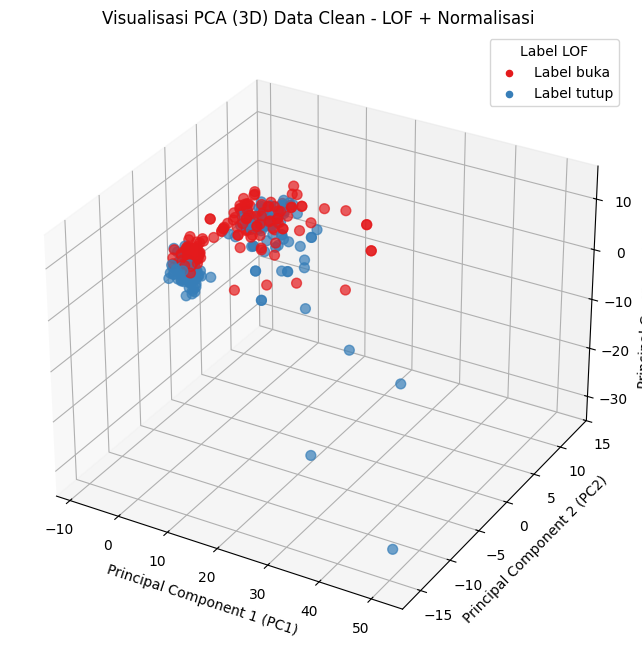

In [19]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import untuk plotting 3D
import seaborn as sns # Tetap bisa digunakan untuk palet warna

# Reduksi dimensi ke 3 komponen utama
pca = PCA(n_components=3)
# Pastikan X_scaled adalah data yang sudah diskalakan (input untuk PCA)
X_pca = pca.fit_transform(X_scaled) 

# Buat dataframe untuk visualisasi
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_lof.values 

# Plot hasil PCA dalam 3D
fig = plt.figure(figsize=(10, 8))
# Buat subplot 3D
ax = fig.add_subplot(111, projection='3d') 

# Ambil warna dari palet 'Set1' sesuai jumlah label unik
colors = sns.color_palette('Set1', n_colors=len(df_pca['label'].unique()))
color_map = {label: colors[i] for i, label in enumerate(df_pca['label'].unique())}
df_pca['color'] = df_pca['label'].map(color_map)

# Scatter plot 3D
# Menggunakan 'c' untuk warna, 'marker' untuk bentuk
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
           c=df_pca['color'], 
           marker='o', 
           s=50, # Ukuran titik
           alpha=0.7) # Transparansi

# Tambahkan label sumbu
ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')
ax.set_title('Visualisasi PCA (3D) Data Clean - LOF + Normalisasi')

# Tambahkan legenda (sedikit lebih kompleks dalam 3D, ini adalah cara dasarnya)
for label, color in color_map.items():
    ax.scatter([], [], [], # Plot titik kosong
               c=color, 
               marker='o', 
               label=f'Label {label}') # Tambahkan label
ax.legend(title='Label LOF')

plt.show()

## **Modelling menggunakan RandomForest**

In [20]:
# === 1. Import library ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 2. Load dataset dari Drive ===
df = pd.read_csv("fitur_tsfel_clean.csv")

# === 3. Pisahkan fitur dan label ===
X = df.drop(columns=['label'])
y = df['label']

# === 4. Split data (80% train, 20% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data training:", len(X_train))
print("Jumlah data testing:", len(X_test))

Jumlah data training: 304
Jumlah data testing: 76


✅ Akurasi Model Random Forest: 0.9737

=== Classification Report ===
              precision    recall  f1-score   support

        buka       0.95      1.00      0.97        38
       tutup       1.00      0.95      0.97        38

    accuracy                           0.97        76
   macro avg       0.97      0.97      0.97        76
weighted avg       0.97      0.97      0.97        76



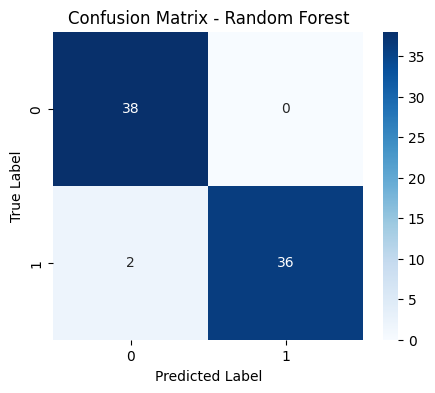

In [21]:
# === 5. Inisialisasi dan latih model Random Forest ===
model = RandomForestClassifier(
    n_estimators=200,       # jumlah pohon
    max_depth=None,         # biarkan default (biar fleksibel)
    random_state=42
)
model.fit(X_train, y_train)

# === 6. Prediksi dan evaluasi ===
y_pred = model.predict(X_test)

# Akurasi
akurasi = accuracy_score(y_test, y_pred)
print(f"✅ Akurasi Model Random Forest: {akurasi:.4f}")

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import joblib

# === Simpan model Random Forest ke Drive ===
model_path = "model_randomforest_tsfel.pkl"
joblib.dump(model, model_path)

print(f"✅ Model Random Forest berhasil disimpan di: {model_path}")


✅ Model Random Forest berhasil disimpan di: model_randomforest_tsfel.pkl


: 

### **Link file csv dam Streamlit**
file csv: https://drive.google.com/file/d/11nKbaQVkTcVTqjULN8ia1q2iLu1d9TCw/view?usp=sharing

Streamlit: https://voice-command-buka-tutup-bnmvmm5hxmaharxwrf9jmm.streamlit.app/